# Running Classification Technical Report
Authors: Suyash Kushwaha and Jack Brandt  

Course: CPSC 322

Assignment: Final Project

Date of current version: 1?/??/2024

Did you attempt the bonus? ???

Brief description of project goals:

* Classify running speed based off other metrics
* Learn about random forest classification
* idk, have fun

### Imports

In [15]:
# Imports
import importlib
import matplotlib.pyplot as plt
import numpy as np
# mypytable
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable
# myevaluation
import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as me
# myutils
import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as mu

from mysklearn.myutils import combine_multiple_files

## Step 1: Data Cleaning

### Preprocessing

The data came as a large number of JSON files grouped into folders. Many of the files and folders were empty, so we began by deleting those. Some of the files contained irrelevant data/non-changing data, such as date of birth and device specs, so we also deleted those. What we were left with was three sets of JSON files, aggregator, fitness, and wellness.

* Aggregator: This contains the most info. It has a list of metrics related to stress, calories, heart rate, and minor metrics related to activity
* Fitness: This contains a list of activities and information about them. All of these activities are runs. Has attributes like distance, speed, heart rate, duration
* Wellness: This mainly contained sleep data

### Cleaning/Joining TODO

Many instances in the dataset are missing values, or are just instances with basically no data. TODO: Make copies of the data without these bad instances

Additionally, for this step we combine all of the many JSON files into one. First by joining all files within each folder, simply appending them onto each other. Then join the lists from each folder. 

We also opened the CSV's in Excel to guide our decision-making process for this step.

In [3]:
# Cleaning/Joining...
# SLEEP
# 1. load all files

sleep_file_names = [
    "2021-04-23_2021-08-01_96200873_sleepData.csv",
    "2021-08-01_2021-11-09_96200873_sleepData.csv",
    "2021-11-09_2022-02-17_96200873_sleepData.csv",
    "2022-02-17_2022-05-28_96200873_sleepData.csv",
    "2022-05-28_2022-09-05_96200873_sleepData.csv",
    "2022-09-05_2022-12-14_96200873_sleepData.csv",
    "2022-12-14_2023-03-24_96200873_sleepData.csv",
    "2023-03-24_2023-07-02_96200873_sleepData.csv",
    "2023-07-02_2023-10-10_96200873_sleepData.csv",
    "2023-10-10_2024-01-18_96200873_sleepData.csv",
    "2024-01-18_2024-04-27_96200873_sleepData.csv",
    "2024-04-27_2024-08-05_96200873_sleepData.csv",
    "2024-08-05_2024-11-13_96200873_sleepData.csv"
]

full_sleep_table = combine_multiple_files(sleep_file_names, "csv_converted_data/connect_wellness")

#current_table.pretty_print()
# 3. Basic cleaning
full_sleep_table.remove_rows_with_missing_values()
full_sleep_table.remove_rows_where_col_equal_specified(
    full_sleep_table.column_names.index("sleepWindowConfirmationType"),
    'OFF_WRIST'
)

# This is all of our joined sleep data
#full_sleep_table.pretty_print()
full_sleep_table.save_to_file('joined_nullfree_subsets/full_sleep.csv')

In [4]:
# Repeat for other file sets
# ACTIVITY

acitivity_files_names = [
    "jack-brandt@comcast.net_0_summarizedActivities.csv",
    "jack-brandt@comcast.net_1001_summarizedActivities.csv"
]
full_activity_table = combine_multiple_files(acitivity_files_names, "csv_converted_data/connect_fitness")
full_activity_table.save_to_file('joined_nullfree_subsets/full_activity.csv')

In [5]:
# Repeat for other file sets
# AGGREGATOR

aggregator_file_names = [
    "UDSFile_2021-04-23_2021-08-01.csv",
    "UDSFile_2021-08-01_2021-11-09.csv",
    "UDSFile_2021-11-09_2022-02-17.csv",
    "UDSFile_2022-02-17_2022-05-28.csv",
    "UDSFile_2022-05-28_2022-09-05.csv",
    "UDSFile_2022-09-05_2022-12-14.csv",
    "UDSFile_2022-12-14_2023-03-24.csv",
    "UDSFile_2023-03-24_2023-07-02.csv",
    "UDSFile_2023-07-02_2023-10-10.csv",
    "UDSFile_2023-10-10_2024-01-18.csv",
    "UDSFile_2024-01-18_2024-04-27.csv",
    "UDSFile_2024-04-27_2024-08-05.csv",
    "UDSFile_2024-08-05_2024-11-13.csv",
]

full_aggregator_table = combine_multiple_files(aggregator_file_names, "csv_converted_data/connect_aggregator_data")
full_aggregator_table.save_to_file('joined_nullfree_subsets/full_aggregator.csv')

In [6]:
from datetime import datetime, timedelta

# Load the combined tables
full_activity_table = MyPyTable().load_from_file(
    "joined_nullfree_subsets/full_activity.csv"
)
full_sleep_table = MyPyTable().load_from_file("joined_nullfree_subsets/full_sleep.csv")
full_aggregator_table = MyPyTable().load_from_file("joined_nullfree_subsets/full_aggregator.csv")

# full_activity_table doesn't have a calendarDate column, so we need to add it
# by converting the startTimeLocal column to a date
start_time_index = full_activity_table.column_names.index("startTimeLocal")

# Add the column
full_activity_table.column_names.append("calendarDate")

# Add the calendarDate to each row
for data in full_activity_table.data:
    timestamp = data[start_time_index] / 1000
    dt_object = datetime.fromtimestamp(timestamp)
    date = dt_object.strftime("%Y-%m-%d")
    data.append(date)

# Now we can join the tables
fully_joined_table = (full_activity_table.perform_inner_join(
    full_sleep_table, ["calendarDate"]
)).perform_inner_join(
    full_aggregator_table, ["calendarDate"]
)

stress_dict = {}
calendar_date_index = full_aggregator_table.column_names.index("calendarDate")
stress_index = full_aggregator_table.column_names.index("allDayStress/aggregatorList/0/maxStressLevel")


for row in full_aggregator_table.data:
    stress_dict[row[calendar_date_index]] = row[stress_index]

# Add the stress level to the fully joined table
fully_joined_table.column_names.append("prevDayMaxStressLevel")
fully_joined_table_calender_date_index = fully_joined_table.column_names.index("calendarDate")

for row in fully_joined_table.data:
    calendar_date = row[fully_joined_table_calender_date_index]

    # Get the previous calendar date
    prev_calendar_date = (datetime.strptime(calendar_date, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d")

    # Get the stress level for the previous day
    if prev_calendar_date in stress_dict:
        row.append(stress_dict[prev_calendar_date])
    else:
        row.append(None)

fully_joined_table.save_to_file("processed_data/fully_joined.csv")

In [7]:
columns = ["prevDayMaxStressLevel", "avgHr", "duration", "avgSpeed"]
class_column = "avgSpeed"
column_index = {}

def speed_discretizer(speed):
    if speed < 0.32:
        return "slow"
    elif speed < 0.33:
        return "mild"
    else:
        return "fast"

def heart_rate_discretizer(bpm):
    if(bpm < 150):
        return "low"
    elif(bpm < 165):
        return "mid"

    return "high"

def stress_discretizer(stress):
    if(stress < 90):
        return "low"
    elif(stress < 95):
        return "mid"

    return "high"

def duration_discretizer(duration):
    if(duration < 2_000_000):
        return "low"
    elif(duration < 4_000_000):
        return "mid"

    return "high"

for column in columns:
    column_index[column] = fully_joined_table.column_names.index(column)

data = []

for row in fully_joined_table.data:
    data.append([row[column_index[column]] for column in columns])

table = MyPyTable(column_names=columns, data=data)

# Remove rows with missing values
table.remove_rows_with_missing_values()

# Remove runs that are less than 10 minutes
table.remove_row_if(table.get_index("duration"), lambda x: x < 600000)
table.remove_rows_where_col_equal_specified(table.get_index(class_column), 0)

columns_to_extract = columns.copy()
columns_to_extract.remove(class_column)

table.save_to_file("processed_data/processed_data.csv")

X = [[stress_discretizer(row[0]), heart_rate_discretizer(row[1]), duration_discretizer(row[2])] for row in table.get_data_subset(columns_to_extract, False)]
X_undiscretized = table.get_data_subset(columns_to_extract, False)
y = [speed_discretizer(row) for row in table.get_column(class_column)]


table.compute_summary_statistics(table.column_names).pretty_print()

attribute                      min           max           mid            avg        median
---------------------  -----------  ------------  ------------  -------------  ------------
prevDayMaxStressLevel      60        99            79.5          91.7749        92
avgHr                     125       176           150.5         153.048        153
duration               633362         1.3104e+07    6.8687e+06    2.35486e+06    2.2341e+06
avgSpeed                    0.1722    0.630717      0.401458      0.328749       0.3279


## Class/Attribute Distributions

### Running Speed

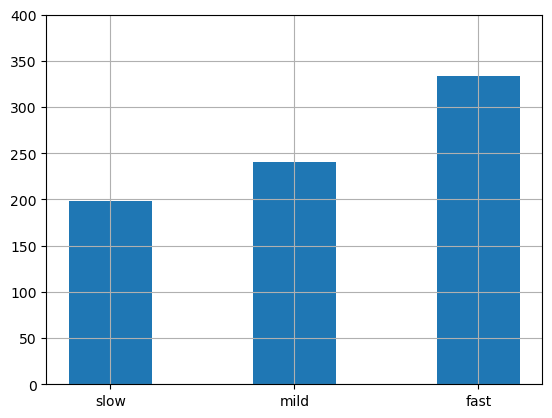

In [ ]:
# reset figure
plt.figure()

# define x and y values
xs = [1, 2, 3]
ys = [y.count('slow'), y.count('mild'), y.count('fast')]

# calculate a range (make y a bit bigger)
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+100, 50)

# create the bar chart (.45 relativebar width)
plt.bar(xrng, ys, 0.45, align="center")
# note: default alignment is center

# define x and y ranges (and value labels)
plt.xticks(xrng, ["slow", "mild", "fast"])
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.show()

### Stress

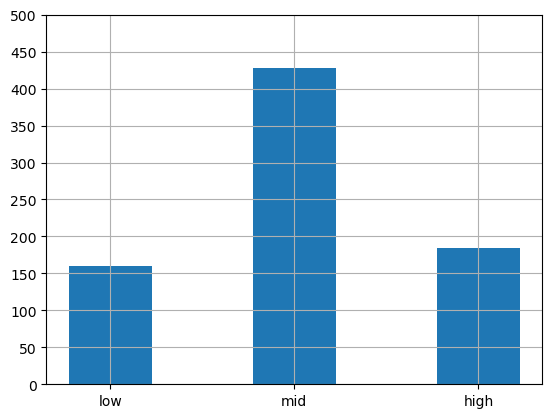

In [20]:
# reset figure
plt.figure()

hist_y = [x[0] for x in X]
ys = [hist_y.count('low'), hist_y.count('mid'), hist_y.count('high')]

# calculate a range (make y a bit bigger)
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+100, 50)

# create the bar chart (.45 relativebar width)
plt.bar(xrng, ys, 0.45, align="center")
# note: default alignment is center

# define x and y ranges (and value labels)
plt.xticks(xrng, ["low", "mid", "high"])
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.show()

### Average HR

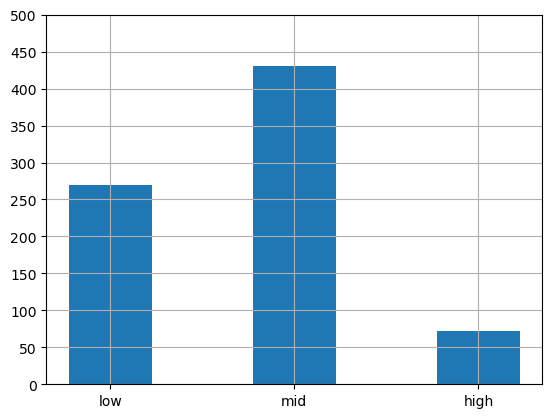

In [21]:
# reset figure
plt.figure()

hist_y = [x[1] for x in X]
ys = [hist_y.count('low'), hist_y.count('mid'), hist_y.count('high')]

# calculate a range (make y a bit bigger)
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+100, 50)

# create the bar chart (.45 relativebar width)
plt.bar(xrng, ys, 0.45, align="center")
# note: default alignment is center

# define x and y ranges (and value labels)
plt.xticks(xrng, ["low", "mid", "high"])
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.show()

### Duration

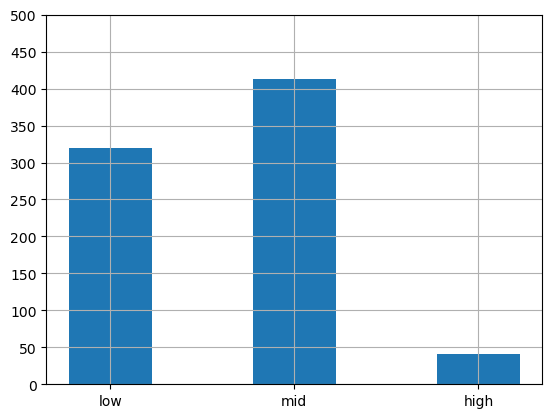

In [23]:
# reset figure
plt.figure()

hist_y = [x[2] for x in X]
ys = [hist_y.count('low'), hist_y.count('mid'), hist_y.count('high')]

# calculate a range (make y a bit bigger)
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+100, 50)

# create the bar chart (.45 relativebar width)
plt.bar(xrng, ys, 0.45, align="center")
# note: default alignment is center

# define x and y ranges (and value labels)
plt.xticks(xrng, ["low", "mid", "high"])
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.show()

## Classification Results

In [9]:
#Set up models # Add more from myclassifiers if time
from mysklearn.myclassifiers import MyDecisionTreeClassifier, MyDummyClassifier, MyKNeighborsClassifier, MyNaiveBayesClassifier, MyRandomForestClassifier


dummy_model = MyDummyClassifier() # Import these from myclassifiers
knn_model = MyKNeighborsClassifier()
bayes_model = MyNaiveBayesClassifier()
tree_model = MyDecisionTreeClassifier()
forest_model = MyRandomForestClassifier()

labels = ['slow','mild','fast']
pos_label='fast'

# Repeat these following two lines for each possible model
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report(dummy_model,10,X,y,labels,pos_label,'Running')
mu.report_metrics_and_confusion('Dummy',metrics, confusion,
    clas_repor)

Dummy Summary Results
1.
    Accuracy: 0.4320827943078913
    Error Rate: 0.5679172056921087
2.
    Precision: 0.4320827943078913
    Recall: 1.0
    F1 measure: 0.6034327009936766
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow            0       0     198      198                  0
mild            0       0     241      241                  0
fast            0       0     334      334                100
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.0          0.0       0           198
mild          0.0          0.0       0           241
fast          0.43         1.0       0.6         334

micro avg     0.43         1.0       0.6         773
macro avg     0.14         0.33      0.2         773
weighted avg  0.19         0.43      0.26        773


In [10]:
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report(knn_model,10,X_undiscretized,y,labels,pos_label,'Running')
mu.report_metrics_and_confusion('KNN',metrics, confusion,
    clas_repor)

KNN Summary Results
1.
    Accuracy: 0.6688227684346701
    Error Rate: 0.33117723156532985
2.
    Precision: 0.7277936962750716
    Recall: 0.7604790419161677
    F1 measure: 0.7437774524158126
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow          118      42      38      198            59.596
mild           39     145      57      241            60.166
fast           30      50     254      334            76.0479
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.63         0.6       0.61        198
mild          0.61         0.6       0.61        241
fast          0.73         0.76      0.74        334

accuracy                             0.67        773
macro avg     0.66         0.65      0.65        773
weighted avg  0.67         0.67      0.67        773


In [11]:
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report(MyNaiveBayesClassifier(),10,X,y,labels,pos_label,'Running')
mu.report_metrics_and_confusion('Bayes',metrics, confusion,
    clas_repor)

Bayes Summary Results
1.
    Accuracy: 0.48253557567917205
    Error Rate: 0.517464424320828
2.
    Precision: 0.5371549893842887
    Recall: 0.7574850299401198
    F1 measure: 0.6285714285714286
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow           99      25      74      198           50
mild           76      21     144      241            8.71369
fast           71      10     253      334           75.7485
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.4          0.5       0.45        198
mild          0.38         0.09      0.14        241
fast          0.54         0.76      0.63        334

accuracy                             0.48        773
macro avg     0.44         0.45      0.41        773
weighted avg  0.45         0.48      0.43        773


In [12]:
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report(tree_model,10,X,y,labels,pos_label,'Running')
mu.report_metrics_and_confusion('Tree',metrics, confusion,
    clas_repor)

Tree Summary Results
1.
    Accuracy: 0.47089262613195343
    Error Rate: 0.5291073738680465
2.
    Precision: 0.5310344827586206
    Recall: 0.6916167664670658
    F1 measure: 0.6007802340702211
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow           96      34      68      198            48.4848
mild           68      37     136      241            15.3527
fast           64      39     231      334            69.1617
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.42         0.48      0.45        198
mild          0.34         0.15      0.21        241
fast          0.53         0.69      0.6         334

accuracy                             0.47        773
macro avg     0.43         0.44      0.42        773
weighted avg  0.44         0.47      0.44        773


In [13]:
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report_forest(forest_model,10,X,y,labels,pos_label,'Running', N=13, M=11, F=1)
mu.report_metrics_and_confusion('Forest',metrics, confusion,
    clas_repor)

Forest Summary Results
1.
    Accuracy: 0.4644243208279431
    Error Rate: 0.535575679172057
2.
    Precision: 0.4828767123287671
    Recall: 0.844311377245509
    F1 measure: 0.6143790849673203
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow           77       0     121      198            38.8889
mild           60       0     181      241             0
fast           52       0     282      334            84.4311
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.41         0.39      0.4         198
mild          0.0          0.0       0           241
fast          0.48         0.84      0.61        334

accuracy                             0.46        773
macro avg     0.3          0.41      0.34        773
weighted avg  0.31         0.46      0.37        773
